# Forecasting Sensitivity for SKA-AA* and SKA-AA4
Authors: Daniela Breitman, Steven G. Murray

In this notebook, we provide an example how to forecast the sensitivity for SKA configurations AA4 and AA* using the new version of 21cmSense.

# Table of Contents

1. [Define the Observatories for each SKA configuration](#define-the-observatories-for-each-ska-configuration)
2. [Set the parameters of the Observation](#set-the-parameters-of-the-observation)
    1. [Deep Survey](#deep-survey)
    2. [Multifield Survey](#multifield-survey)
    3. [HERA-like Drift Scan Survey](#hera-like-drift-scan-survey)
    4. [Deep survey with optimistic foreground removal](#deep-survey-with-optimistic-foreground-removal)
7. [Compare Sensitivities](#compare-sensitivities)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import py21cmsense as p21sense
from astropy import units as un
from astropy.cosmology import Planck15
from matplotlib import colors, rcParams
from py21cmsense.observatory import Observatory
from py21cmsense.sensitivity import PowerSpectrum
from py21cmsense.theory import EOS2021

rcParams.update({"font.size": 20})

Here we define some helper functions. `get_senses` is a function that takes in a `21cmSense.Observation` instance, the frequency bands of the survey, as well as the $k_\perp, k_\parallel$ bins at which we want the sensitivities. This function simply loops over each band and calculates the sensitivity of the given observation at that band and $k_\perp, k_\parallel$ bins.

In [2]:
def freq2z(f):
    """Convert frequency in MHz to redshift."""
    return 1420.4 / f - 1.0


def z2freq(z):
    """Convert redshift to frequency in MHz."""
    return 1420.4 / (z + 1.0)


def get_senses(
    observation,
    freq_bands,
    kperp_edges_hmpc,
    kpar_edges_hmpc,
    calc_2d=False,
    foreground_model="moderate",
    theory_model=EOS2021,
    **kwargs,
):
    """Calculate the sensitivity for a set of frequency bands."""
    h = observation.cosmo.H0.value / 100.0
    redshifts = kwargs["redshifts"]
    mock_senses = {}
    mock_senses["kperp_edges_hMpc"] = kperp_edges_hmpc
    mock_senses["kpar_edges_hMpc"] = kpar_edges_hmpc
    mock_senses["redshifts"] = redshifts
    mock_senses["freq_bands"] = freq_bands
    mock_senses["h"] = h

    for _i, band, zval in zip(range(len(freq_bands)), freq_bands, redshifts):
        this_z = {}
        band_name = str(np.round(band, 1)) + " MHz"

        sense = PowerSpectrum(
            observation=observation, foreground_model=foreground_model, theory_model=theory_model()
        ).at_frequency(band * un.MHz)
        if calc_2d:
            sense2d_sample = sense.calculate_sensitivity_2d_grid(
                kperp_edges=kperp_edges_hmpc, kpar_edges=kpar_edges_hmpc, thermal=False, sample=True
            )
            this_z["sample_2D_mK2"] = sense2d_sample.value

            sense2d_thermal = sense.calculate_sensitivity_2d_grid(
                kperp_edges=kperp_edges_hmpc, kpar_edges=kpar_edges_hmpc, thermal=True, sample=False
            )
            this_z["thermal_2D_mK2"] = sense2d_thermal.value

            both = np.sqrt(sense2d_sample.value**2 + sense2d_thermal.value**2)
            this_z["sample_and_thermal_2D_mK2"] = both

        sense1d_sample = sense.calculate_sensitivity_1d(thermal=False, sample=True)
        this_z["sample_1D_mK2"] = sense1d_sample.value
        this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
            zval, sense.k1d.value * mock_senses["h"]
        ).value

        this_z["k_1D_Mpc"] = sense.k1d.value * mock_senses["h"]
        sense1d_thermal = sense.calculate_sensitivity_1d(thermal=True, sample=False)
        this_z["thermal_1D_mK2"] = sense1d_thermal.value

        sense1d_both = sense.calculate_sensitivity_1d(thermal=True, sample=True)
        this_z["sample_and_thermal_1D_mK2"] = sense1d_both.value
        mock_senses[band_name] = this_z
    return mock_senses

## Define the Observatories for each SKA configuration <a class="anchor" id="define-the-observatories-for-each-ska-configuration"></a>
In this tutorial, we will produce sensitivity estimates for two SKA configurations: AA* and AA4.

In [ ]:
aaast = Observatory.from_ska("AA*")
aa4 = Observatory.from_ska("AA4")

The two configurations differ from each other in the following ways:
- AA4 has more stations (512) than AA* (307)
- AA4 has more stations clustered at the centre than AA*

Let's check this by plotting the station layouts of each experiment:

AA* has 307 antennas
AA4 has 512 antennas


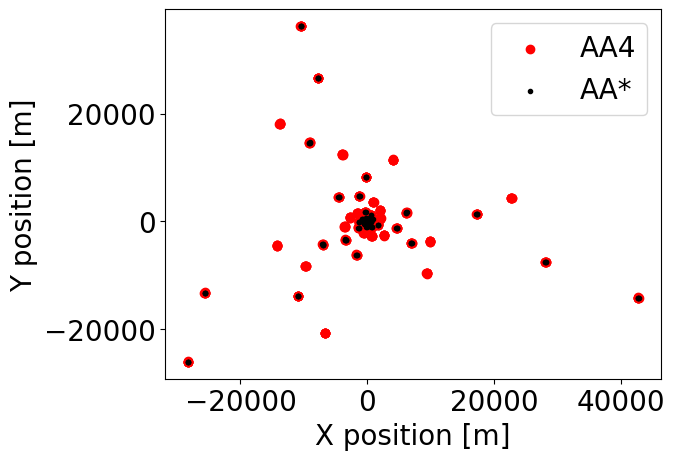

In [4]:
aaast_antpos = aaast.antpos.value[:, :2]  # exclude z position
aa4_antpos = aa4.antpos.value[:, :2]  # exclude z position
print("AA* has", aaast_antpos.shape[0], "antennas")
print("AA4 has", aa4_antpos.shape[0], "antennas")
plt.scatter(aa4_antpos[:, 0], aa4_antpos[:, 1], label="AA4", color="r")
plt.scatter(aaast_antpos[:, 0], aaast_antpos[:, 1], label="AA*", color="k", marker=".")
plt.legend()
plt.ylabel("Y position [m]")
plt.xlabel("X position [m]")
plt.show()

We can also plot the baseline distribution produced by each experiment:

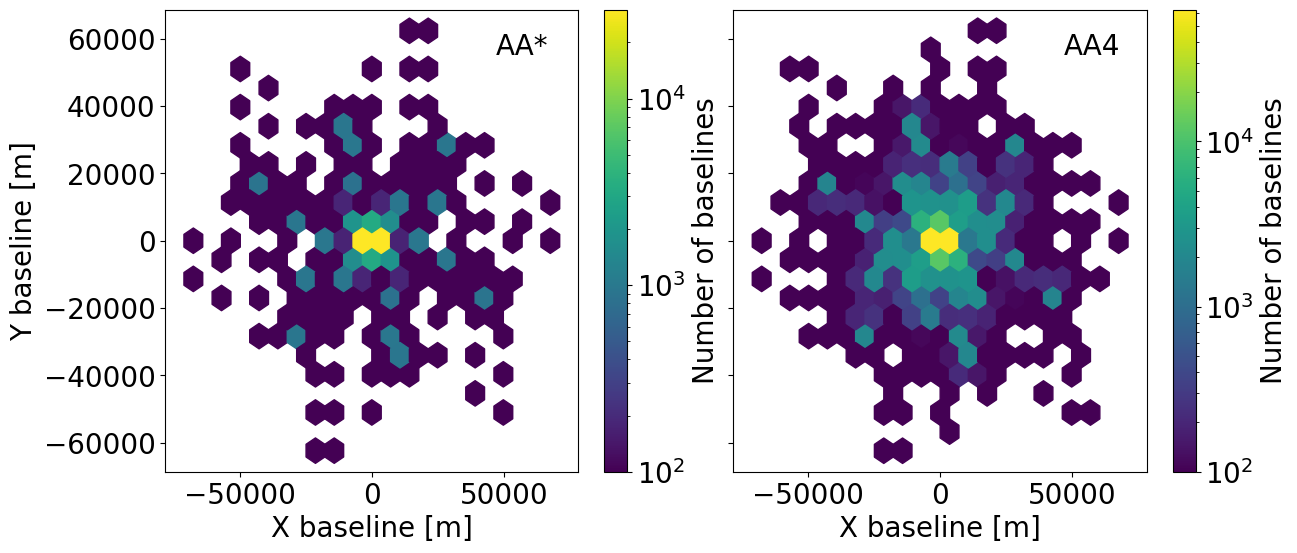

In [5]:
# aa4.baselines_metres has shape (Nants, Nants, 3):
# it gives us the basline vectors between all pairs of antennas in x,y,z.
# We ignore the z coordinate and plot the x and y baselines for all antenna pairs.
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
im = ax[0].hexbin(
    aaast.baselines_metres[:, :, 0].ravel(),
    aaast.baselines_metres[:, :, 1].ravel(),
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
im = ax[1].hexbin(
    aa4.baselines_metres[:, :, 0].ravel(),
    aa4.baselines_metres[:, :, 1].ravel(),
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.8, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top")
plt.show()

This plot shows us that while we have a very wide range of baselines available, the baseline density is highest at shorter baselines due to the clustering of the stations. Let's zoom in on this region:

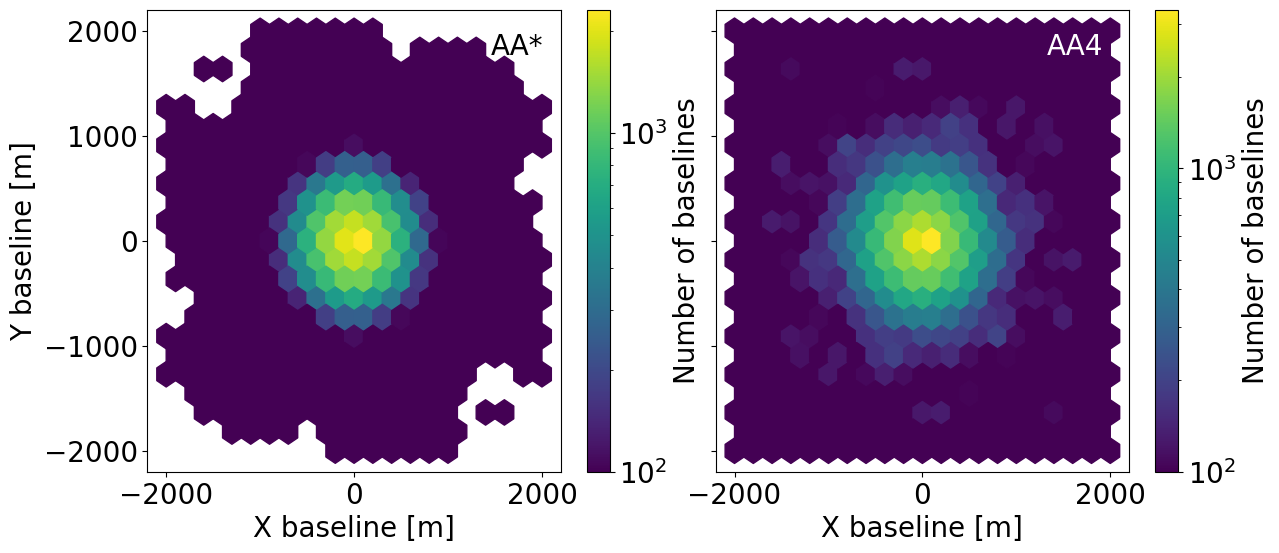

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
m = np.logical_and(
    abs(aaast.baselines_metres[:, :, 0].ravel().value) < 2000,
    abs(aaast.baselines_metres[:, :, 1].ravel().value) < 2000,
)
im = ax[0].hexbin(
    aaast.baselines_metres[:, :, 0].ravel()[m],
    aaast.baselines_metres[:, :, 1].ravel()[m],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
m = np.logical_and(
    abs(aa4.baselines_metres[:, :, 0].ravel().value) < 2000,
    abs(aa4.baselines_metres[:, :, 1].ravel().value) < 2000,
)
im = ax[1].hexbin(
    aa4.baselines_metres[:, :, 0].ravel()[m],
    aa4.baselines_metres[:, :, 1].ravel()[m],
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.83, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(
    0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top", color="w"
)
plt.show()

This plot shows us that the bulk of the baselines are less than 1km for both instrument configurations (although more so for AA* than AA4). Baselines with low density will not contribute significantly to the sensitivity estimates. This will be useful shortly, when we define our `21cmSense.Observation` instance.


For these two SKA anteanna layouts, we will now consider four different observational strategies:
- Three surveys assuming a moderate foreground removal model where we exclude all k-modes below the horizon limit plus a buffer of $0.1 hMpc^{-1}$ (default value)
- One survey assuming an optimistic foreground removal where we exclude all k-modes smaller than the primary field of view.

## Set the parameters of the Observation <a class="anchor" id="set-the-parameters-of-the-observation"></a>
We choose the centres of the frequency bands for which we want to forecast the sensitivity. By default, each frequency band has a width of 8 MHz. The values chosen here are illustrative.
We put the observation parameters into `observation_params` for convenience.

In [7]:
freq_bands = np.array([60.0, 80.0, 120.0, 125.0, 140.0, 160.0, 180.0, 200.0, 215.0])  # MHz
zs = freq2z(freq_bands)

In [8]:
observation_params = {}
observation_params["ndays"] = 180.0
observation_params["cosmo"] = Planck15
observation_params["h"] = Planck15.H0.value / 100.0
observation_params["freq_bands"] = freq_bands
observation_params["redshifts"] = zs
observation_params["time_per_day_hrs"] = 6.0

The sensitivity calculation requires the $k_\perp, k_\parallel$ bin edges at which we want to calculate the sensitivity.
We put these and other information, such as the foreground mitigation model we want to use, into `sense_params`.

In [9]:
# Only needed if we want to calculate the 2D sensitivity
# Set the kperp and kpar bins at which we want to calculate the 2D sensitivity
sense_params = {}
sense_params["calc_2d"] = True
sense_params["foreground_model"] = "moderate"
sense_params["redshifts"] = zs
sense_params["freq_bands"] = freq_bands
sense_params["kperp_edges_hmpc"] = un.Quantity(np.logspace(-1.5, 0.3, 15), "littleh/Mpc")
sense_params["kpar_edges_hmpc"] = un.Quantity(np.logspace(-1.5, 0.3, 15), "littleh/Mpc")
sense_params["kpar_mpc"] = (
    np.exp(
        (
            np.log(sense_params["kpar_edges_hmpc"].value[:-1])
            + np.log(sense_params["kpar_edges_hmpc"].value[1:])
        )
        / 2
    )
    * observation_params["h"]
)
sense_params["kperp_mpc"] = (
    np.exp(
        (
            np.log(sense_params["kperp_edges_hmpc"].value[:-1])
            + np.log(sense_params["kperp_edges_hmpc"].value[1:])
        )
        / 2
    )
    * observation_params["h"]
)

Now that we've set the parameters that are common to all observations, let's define each of the four surveys:
1. We observe the sky for 6 hours a day and track the same patch of sky during the entire observation (single deep field)
2. We observe the sky for 6 hours a day and track the same patch of sky for 3 hours before switching to a different patch (multiple fields but less deep)
3. We observe the sky for 6 hours a day and do not track i.e. drift scan mode (HERA-like)
4. Survey 1. + optimistic foreground removal model

Note that in each case a "field" or a "patch of sky" is defined by the beam of the instrument which is assumed to be Gaussian. We can check the area of the beam (which is frequency-dependent) by doing the following:

In [10]:
print(f"AA* beam area:{aaast.beam.area.value:.5f} rad2")  # for 150 MHz (default value)
print(f"AA4 beam area:{aa4.beam.area.value:.5f} rad2")

AA* beam area:0.00350 rad2
AA4 beam area:0.00350 rad2


The beam areas of the two SKA configurations are the same because it only depends on the dish size and frequency, which are the same for both configurations here.

We will recycle the observation parameters from above in all three cases i.e. in all surveys, we consider 180 days of observation with 6 hours per day, and estimate the sensitivity at the same frequencies and same k-bins.

### Deep survey <a id="deep-survey"></a>

We set the number of tracking hours to be the same as the number of observation hours per day to obtain the deepest observation possible.
Note that the argument for the number of tracking hours is called `lst_bin_size`.


Using these observation parameters, we create an instance of the `21cmSense.Observation` class. 

Earlier, we looked at the baseline distribution for both SKA layouts and found that the bulk of the baselines are shorter than 1 km.
While longer baselines are crucial in a real observation (e.g. for calibration purposes), here we include a baseline filter to exclude baselines greater than 1 km as it significantly decreases the computation time and they will not contribute at all to the sensitivity at the scales considered in this tutorial (for an illustration of the baseline value as a function of frequency and $k_\perp$ see Gorce+23 Fig.3). 

In [11]:
obs = p21sense.Observation(
    observatory=aa4,
    lst_bin_size=observation_params["time_per_day_hrs"] * un.hour,
    time_per_day=observation_params["time_per_day_hrs"] * un.hour,
    n_days=observation_params["ndays"],
    cosmo=observation_params["cosmo"],
    coherent=True,
    # To point to dish off-zenith, use: phase_center_dec=-30.0*un.deg,
    # max baseline is 73km and there are ~260k bls so the gridding takes a very long time.
    # we add a baseline filer to only keep baselines up to 1km.
    baseline_filters=p21sense.BaselineRange(bl_max=1e3 * un.m),
)

We calculate the sensitivity for each frequency band for the AA4 configuration:

In [ ]:
ska_aa4_senses1 = get_senses(
    obs,
    **sense_params,
)

We clone the `21cmSense.Observation` instance we just made and switch the observatory from AA4 to AA*:

In [13]:
obs = obs.clone(observatory=aaast)

In [ ]:
ska_aaast_senses1 = get_senses(
    obs,
    **sense_params,
)

### Multifield Survey <a id="multifield-survey"></a>
We set the number of tracking hours to 3 hours to enable the tracking of multiple fields.

In [15]:
obs = obs.clone(observatory=aa4, lst_bin_size=3.0 * un.hour)

In [ ]:
ska_aa4_senses2 = get_senses(
    obs,
    **sense_params,
)

We clone the `21cmSense.Observation` instance and switch the observatory from AA4 to AA*:

In [17]:
obs = obs.clone(observatory=aaast)

In [ ]:
ska_aaast_senses2 = get_senses(
    obs,
    **sense_params,
)

### HERA-like Drift Scan survey <a id="hera-like-drift-scan-survey"></a>
We set the number of tracking hours to the beam-crossing time (i.e. the time it takes for the sky to drift through the beam FWHM) to disable tracking and operate in drift scan mode.

In [19]:
obs = obs.clone(
    observatory=aa4,
    lst_bin_size=aa4.observation_duration,  # beam-crossing time
)

In [ ]:
ska_aa4_senses3 = get_senses(
    obs,
    **sense_params,
)

We clone the `21cmSense.Observation` instance and switch the observatory from AA4 to AA*:

In [21]:
obs = obs.clone(
    observatory=aaast,
    lst_bin_size=aaast.observation_duration,  # beam-crossing time
)

In [ ]:
ska_aaast_senses3 = get_senses(
    obs,
    **sense_params,
)

### Deep survey with optimistic foreground removal <a id="deep-survey-with-optimistic-foreground-removal"></a>

We set the foreground model to `optimistic`, and, as in the deep survey, set the `lst_bin_size` back to the number of daily observation hours:

In [23]:
sense_params["foreground_model"] = "optimistic"

In [24]:
obs = obs.clone(observatory=aa4, lst_bin_size=observation_params["time_per_day_hrs"] * un.hour)

We calculate the sensitivity for each frequency band for the AA4 configuration:

In [ ]:
ska_aa4_senses4 = get_senses(
    obs,
    **sense_params,
)

We clone the `21cmSense.Observation` instance and switch the observatory from AA4 to AA*:

In [26]:
obs = obs.clone(observatory=aaast)

In [ ]:
ska_aaast_senses4 = get_senses(
    obs,
    **sense_params,
)

## Compare sensitivities <a class="anchor" id="compare-sensitivities"></a>
We compare the sensitivity curves for the four surveys and two SKA instrument configurations. 
To do so, we first define some plotting functions:

In [49]:
def compare_senses(
    senses1,
    senses2,
    redshift,
    kperp_mpc,
    kpar_mpc,
    label1="AA*",
    label2="AA4",
    plot_1d=True,
    **kwargs,
):
    """Plot the 2D sensitivity of two observations at a given redshift."""
    # We assume both senses have the same redshifts / freq bands
    if np.all(senses1["redshifts"] != senses2["redshifts"]):
        raise ValueError("Redshifts do not match")
    closest_redshift = np.argmin(np.abs(senses1["redshifts"] - redshift))
    band_name = str(np.round(z2freq(senses1["redshifts"][closest_redshift]), 1)) + " MHz"
    if (
        "sample_and_thermal_2D_mK2" in senses1[band_name]
        and "sample_and_thermal_2D_mK2" in senses2[band_name]
    ):
        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
        mask1 = ~np.logical_or(
            np.isinf(senses1[band_name]["sample_and_thermal_2D_mK2"]),
            np.isnan(senses1[band_name]["sample_and_thermal_2D_mK2"]),
        )
        mask2 = ~np.logical_or(
            np.isinf(senses2[band_name]["sample_and_thermal_2D_mK2"]),
            np.isnan(senses2[band_name]["sample_and_thermal_2D_mK2"]),
        )
        vmin = np.min(
            [
                np.nanpercentile(senses1[band_name]["sample_and_thermal_2D_mK2"][mask1].ravel(), 5),
                np.nanpercentile(senses2[band_name]["sample_and_thermal_2D_mK2"][mask2].ravel(), 5),
            ]
        )
        vmax = np.nanmin(
            [
                np.nanpercentile(
                    senses1[band_name]["sample_and_thermal_2D_mK2"][mask1].ravel(), 90
                ),
                np.nanpercentile(
                    senses2[band_name]["sample_and_thermal_2D_mK2"][mask2].ravel(), 90
                ),
            ]
        )
        ax[0].pcolormesh(
            kperp_mpc,
            kpar_mpc,
            senses1[band_name]["sample_and_thermal_2D_mK2"].T,
            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
        )
        ax[0].set_title(label1)
        ax[0].loglog()

        im = ax[1].pcolormesh(
            kperp_mpc,
            kpar_mpc,
            senses2[band_name]["sample_and_thermal_2D_mK2"].T,
            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
        )
        ax[1].set_title(label2)
        ax[1].loglog()
        plt.suptitle("Redshift z = " + str(np.round(redshift, 1)))
        fig.colorbar(im, label=r"sensitivity [mK$^2$]")
        ax[0].set_xlabel(r"$k_\perp$ [Mpc$^{-1}$]")
        ax[1].set_xlabel(r"$k_\perp$ [Mpc$^{-1}$]")
        ax[0].set_ylabel(r"$k_\parallel$ [Mpc$^{-1}$]")
        plt.show()
    if plot_1d:
        plt.plot(
            senses1[band_name]["k_1D_Mpc"],
            senses1[band_name]["sample_and_thermal_1D_mK2"],
            label=label1,
        )
        plt.plot(
            senses2[band_name]["k_1D_Mpc"],
            senses2[band_name]["sample_and_thermal_1D_mK2"],
            label=label2,
        )
        plt.yscale("log")
        plt.title(band_name)
        plt.xlabel(r"k [Mpc$^{-1}$]")
        plt.ylabel(r"$\log_{10}$ sensitivity [mK$^2$]")
        plt.legend(frameon=False)
        plt.show()


def compare_all_senses(senses, redshift=None, k=None, labels=None, colors=None, lss=None):
    """Plot the sensitivity of observations at a given z vs k and at a given k vs z."""
    # We assume all senses have the same redshifts / freq bands and k bins
    closest_redshift = np.argmin(np.abs(senses[0]["redshifts"] - redshift))
    band_name = str(np.round(z2freq(senses[0]["redshifts"][closest_redshift]), 1)) + " MHz"
    all_band_names = [str(np.round(z2freq(i), 1)) + " MHz" for i in senses[0]["redshifts"]]
    closest_k = np.argmin(np.abs(senses[0][band_name]["k_1D_Mpc"] - k))
    # plot sens vs z at fixed k
    fig, ax = plt.subplots(
        1, 1, figsize=(12, 6), sharex=True, layout="constrained", gridspec_kw={"hspace": 0.05}
    )
    ax = [ax]
    for i, sense in enumerate(senses):
        sensitivity_at_k = np.array(
            [sense[band]["sample_and_thermal_1D_mK2"][closest_k] for band in all_band_names]
        )
        theory_at_k = np.array([sense[band]["theory_1D_mK2"][closest_k] for band in all_band_names])
        m = np.isinf(sensitivity_at_k)
        ax[0].plot(
            sense["redshifts"][~m],
            sensitivity_at_k[~m],
            color=colors[i] if colors is not None else None,
            ls=lss[i] if lss is not None else None,
            label="sensitivity" if i == 6 else None,
        )
        if i == 6:
            ax[0].plot(
                sense["redshifts"][~m],
                theory_at_k[~m],
                label="EOS2021" if i == 6 else None,
                color="blueviolet",
                alpha=0.6,
                lw=2,
                ls=lss[i] if lss is not None else None,
            )
    ax[0].set_xlabel("Redshift")
    ax[0].set_ylabel(r"$\Delta^2_{21}$ [mK$^2$]")
    ax[0].set_yscale("log")
    if labels is not None:
        plt.legend(frameon=False, fontsize=18, loc="upper left")
    ylims = ax[0].get_ylim()
    xlims = ax[0].get_xlim()
    plt.text(
        xlims[0] * 1.1,
        ylims[1] * 0.1,
        "k = " + str(np.round(senses[0][band_name]["k_1D_Mpc"][closest_k], 2)) + " Mpc$^{-1}$",
        fontsize=20,
    )
    plt.show()

    # plot sens vs k at fixed z
    fig, ax = plt.subplots(
        1, 1, figsize=(12, 6), sharex=True, layout="constrained", gridspec_kw={"hspace": 0.05}
    )
    ax = [ax]
    for i, sense in enumerate(senses):
        sensitivity_at_z = sense[band_name]["sample_and_thermal_1D_mK2"]
        m = np.isinf(sensitivity_at_z)
        ax[0].plot(
            sense[band_name]["k_1D_Mpc"][~m],
            sensitivity_at_z[~m],
            color=colors[i] if colors is not None else None,
            ls=lss[i] if lss is not None else None,
            label=labels[i] if labels is not None else None,
        )
        if i == 6:
            ax[0].plot(
                sense[band_name]["k_1D_Mpc"][~m],
                sense[band_name]["theory_1D_mK2"][~m],
                color="blueviolet",
                alpha=0.6,
                lw=2,
                ls=lss[i] if lss is not None else None,
            )
    ax[0].set_xlabel(r"k [Mpc$^{-1}$]")
    ax[0].set_ylabel(r"$\Delta^2_{21}$ [mK$^2$]")
    ax[0].set_yscale("log")
    ax[0].set_xscale("log")
    if labels is not None:
        plt.legend(frameon=False, fontsize=16)
    ylims = ax[0].get_ylim()
    xlims = ax[0].get_xlim()
    ax[0].text(xlims[1] * 0.3, ylims[1] * 0.35, "f = " + band_name, fontsize=20)
    ax[0].text(
        xlims[1] * 0.3,
        ylims[1] * 0.6,
        "z = " + str(np.round(senses[0]["redshifts"][closest_redshift])),
        fontsize=20,
    )
    plt.show()

Here, we plot the sensitivity of the three surveys and two SKA configurations for a fixed wavemode (plot 1) and fixed redshift (plot 2):

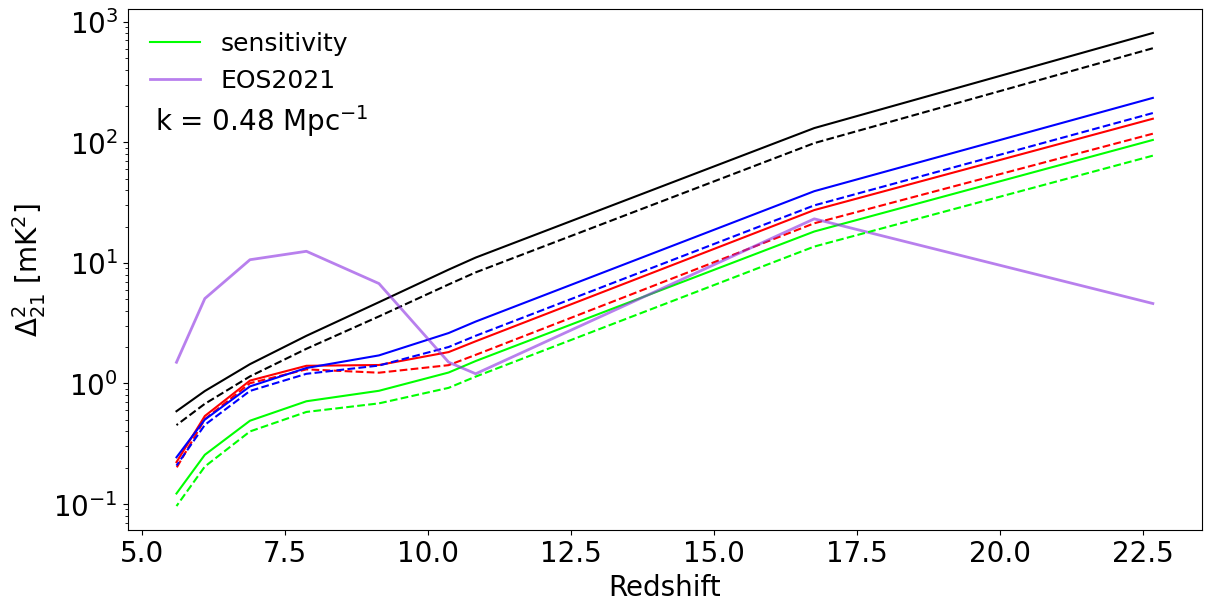

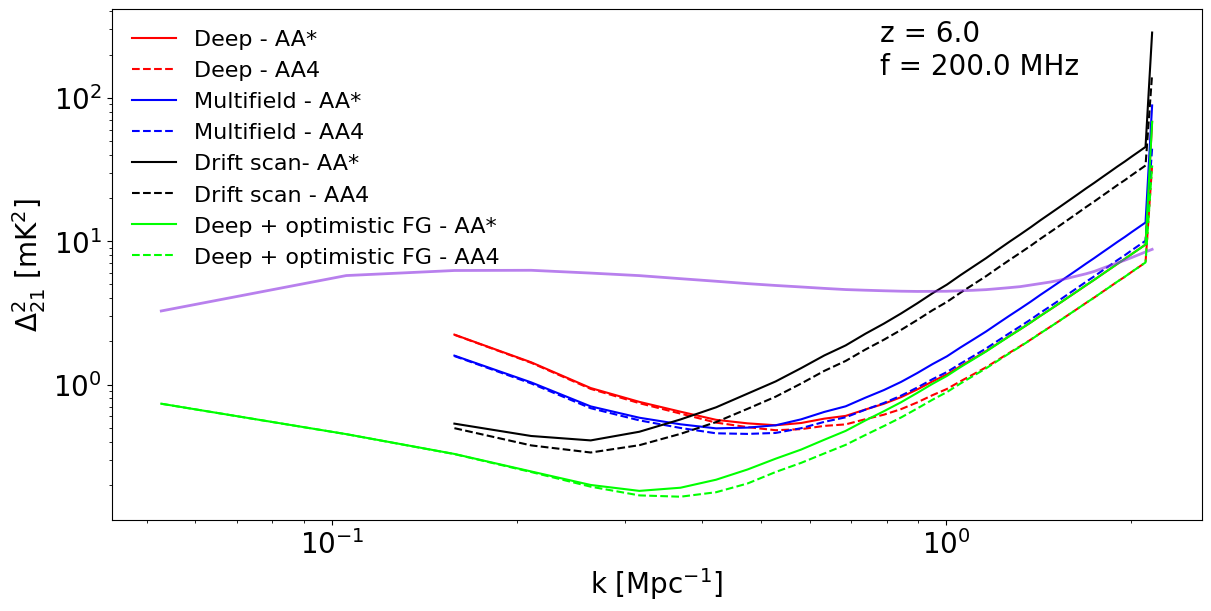

In [50]:
compare_all_senses(
    [
        ska_aaast_senses1,
        ska_aa4_senses1,
        ska_aaast_senses2,
        ska_aa4_senses2,
        ska_aaast_senses3,
        ska_aa4_senses3,
        ska_aaast_senses4,
        ska_aa4_senses4,
    ],
    6.1,  # redshift value for second plot
    0.5,  # k value for first plot
    labels=[
        "Deep - AA*",
        "Deep - AA4",
        "Multifield - AA*",
        "Multifield - AA4",
        "Drift scan- AA*",
        "Drift scan - AA4",
        "Deep + optimistic FG - AA*",
        "Deep + optimistic FG - AA4",
    ],
    colors=["r", "r", "b", "b", "k", "k", "lime", "lime"],
    lss=["-", "--", "-", "--", "-", "--", "-", "--"],
)

In these plots, we plot the theory model EOS2021 in purple, while all other lines are sensitivities. Plotting them this way provides a convenient way to see what is detectable and what isn't: when the sensitivity is below the 21-cm PS model, we expect the signal to be detectable, while when the sensitivity values are much higher than the model, we should not expect a detection.

Looking at the sensitivity vs redshift plot, we can see that the deep survey (red) has better sensitivity than the multifield (blue) and the drift scan (black) surveys at small scales due to smaller thermal variance. At larger scales, cosmic variance dominates over the thermal noise of the instrument. At such, the multifield and drift scan surveys perform better than the deep field due to the fact that they have a lower cosmic variance contribution from the averaging of multiple fields as $\sigma_{\rm samp} \sim \frac{\Delta^2_{21}}{\sqrt{N_f}},$ where $N_f = \frac{\rm{observation.time\_per\_day}}{\rm{observation.lst\_bin\_size}}$ is the number of fields of the observation.
To see this, let's plot the contribution of sample and thermal variance individually for the multifield survey:

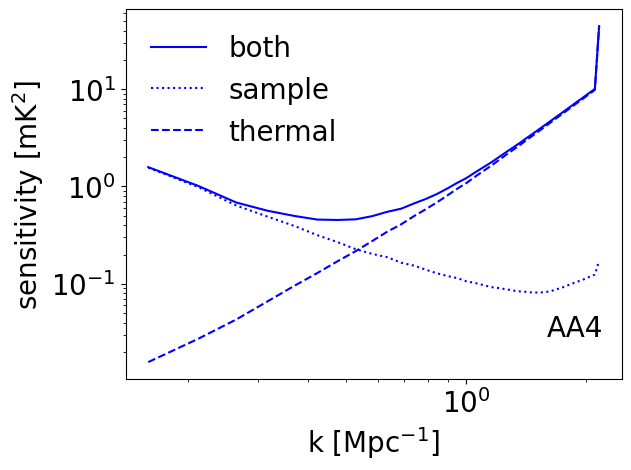

In [30]:
plt.plot(
    ska_aa4_senses2["200.0 MHz"]["k_1D_Mpc"],
    ska_aa4_senses2["200.0 MHz"]["sample_and_thermal_1D_mK2"],
    label="both",
    color="b",
)
plt.plot(
    ska_aa4_senses2["200.0 MHz"]["k_1D_Mpc"],
    ska_aa4_senses2["200.0 MHz"]["sample_1D_mK2"],
    label="sample",
    color="b",
    ls=":",
)
plt.plot(
    ska_aa4_senses2["200.0 MHz"]["k_1D_Mpc"],
    ska_aa4_senses2["200.0 MHz"]["thermal_1D_mK2"],
    label="thermal",
    color="b",
    ls="--",
)
plt.loglog()
plt.xlabel(r"k [Mpc$^{-1}$]")
plt.ylabel(r"sensitivity [mK$^2$]")
plt.legend(frameon=False)
plt.text(0.85, 0.1, "AA4", transform=plt.gca().transAxes, fontsize=20, verticalalignment="bottom")
plt.show()

Looking back at the previous plots comparing all the observations, the optimistic foreground mitigation model (green) significanly extends the range of large-scale modes available while also significantly improving the sensitivity at large scales  at $k\sim 0.2 - 0.6 Mpc^{-1}$. As expected, it does not affect small scales (beyond $k\sim 1.0 Mpc^{-1}$).


The SKA-AA4 layout (dashed lines) always has better sensititivity than the SKA-AA* layout (solid lines). This expected not only because AA4 has more stations than AA*, but also because AA4 has more stations clustered at the centre. These clustered stations increase the number of small baselines available and hence improve the sensitivity in the wavemode range considered here.

The sensitivities include both thermal variance (due to the instrument) and cosmic variance (due to fewer modes at large scales). To estimate the cosmic variance, we need a model for the 21-cm power spectrum. The default 21-cm PS theory model used by 21cmSense is EOS2021 (Muñoz+21), a 1.5 Gpc high-resolution (1.5 Mpc per cell) simulation made with 21cmFAST including both Pop II and Pop III stars. For a more accurate cosmic variance estimation for your specific 21-cm PS model, you can swap out this default model for your own by subclassing `21cmSense.theory.TheoryModel` and passing it to `get_senses` via the `theory_model` argument. This is especially important when the 21-cm PS model for which you want to estimate the sensitivities is very different from the default model, as the sample variance contribution to the sensitivity can be non-negligible!

We can also look at the sensitivities of each survey in 2D for some set of redshifts `z_idx`. This allows us to explicitly see the $k_\perp, k_\parallel$ bins available for different instrument configurations, frequencies, and foreground removal strategies.

In [31]:
z_idx = [1, 5, 8]
print(
    "We will plot the 2D sensitivities for the two SKA configurations at redshifts:",
    zs[::-1][z_idx],
)

We will plot the 2D sensitivities for the two SKA configurations at redshifts: [ 6.102      10.3632     22.67333333]


## Deep survey

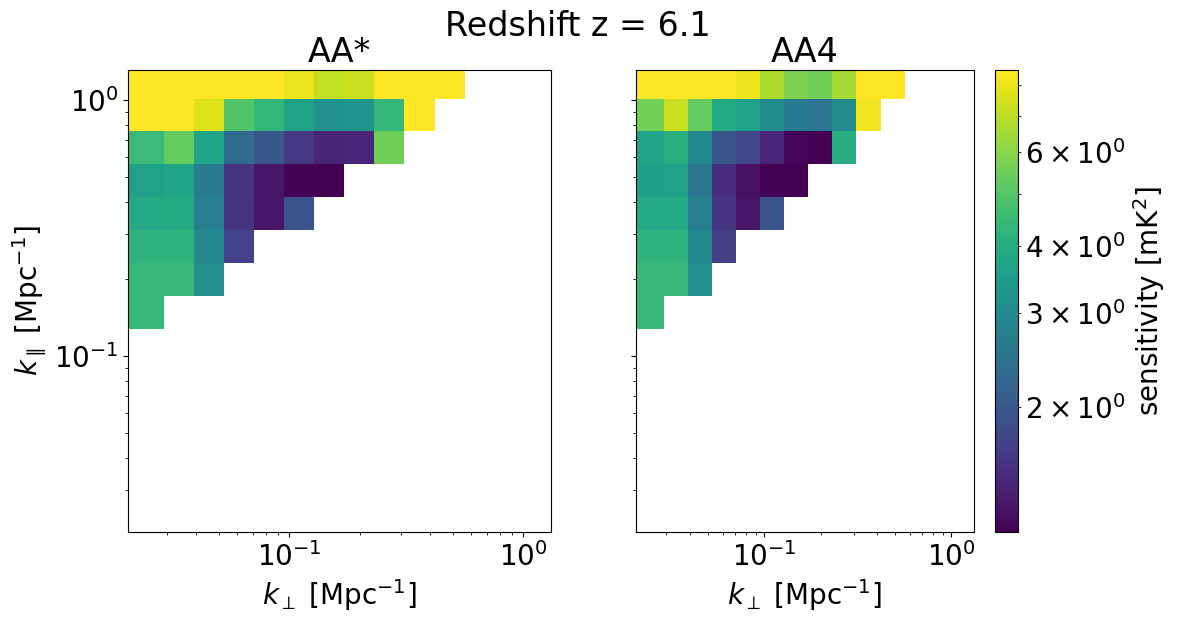

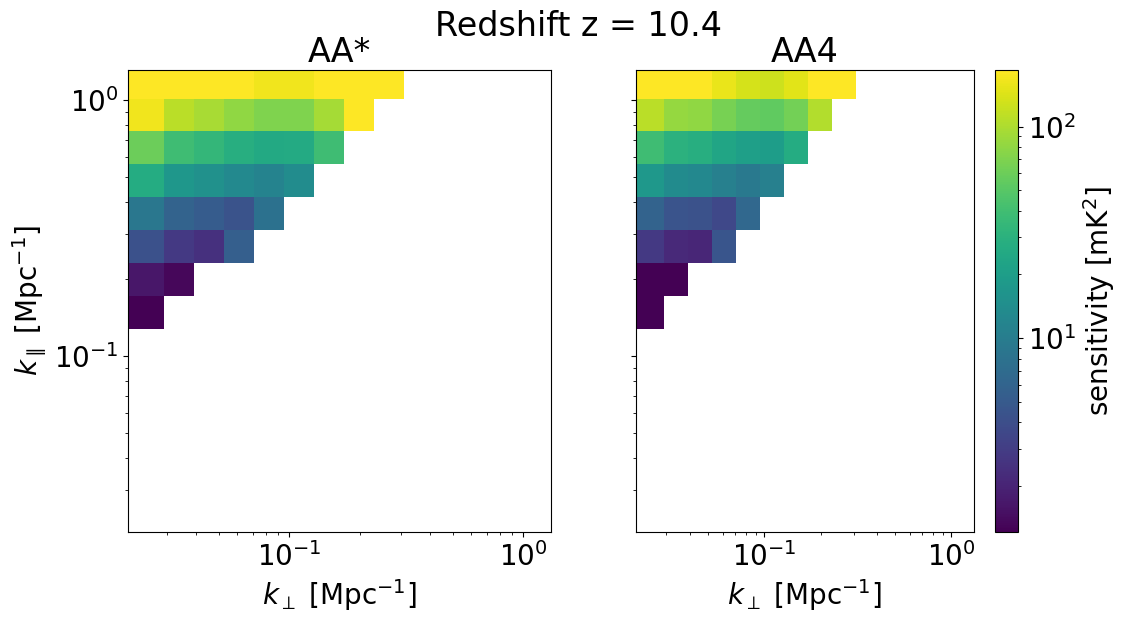

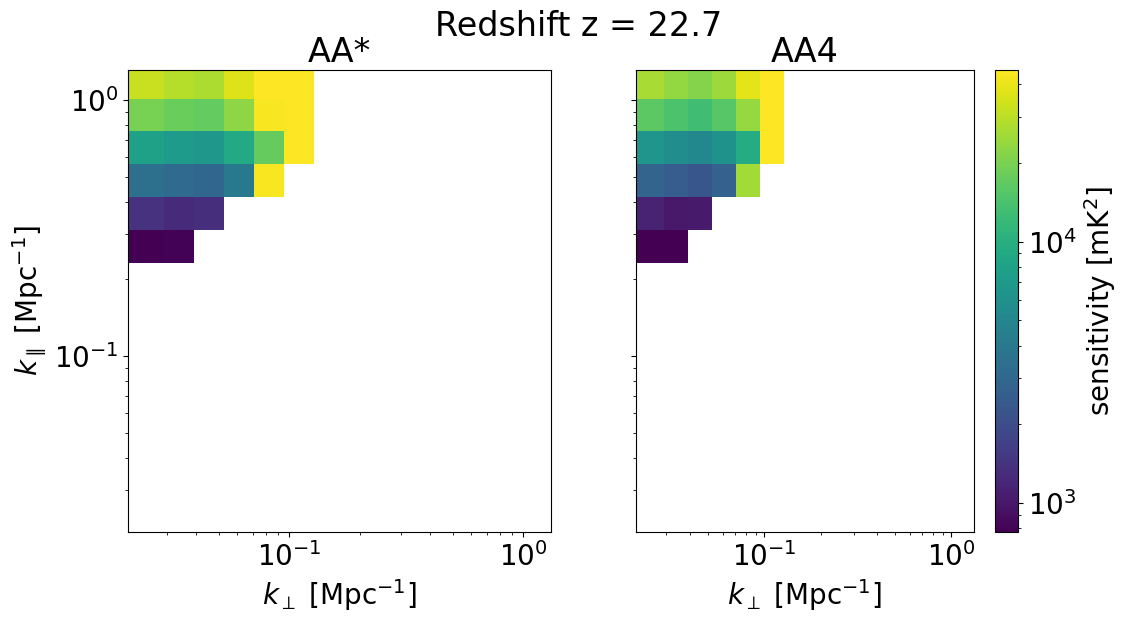

In [33]:
for z in zs[::-1][z_idx]:
    compare_senses(
        ska_aaast_senses1,
        ska_aa4_senses1,
        z,
        sense_params["kperp_mpc"],
        sense_params["kpar_mpc"],
        label1="AA*",
        label2="AA4",
        plot_1d=False,
    )

## Multifield Survey

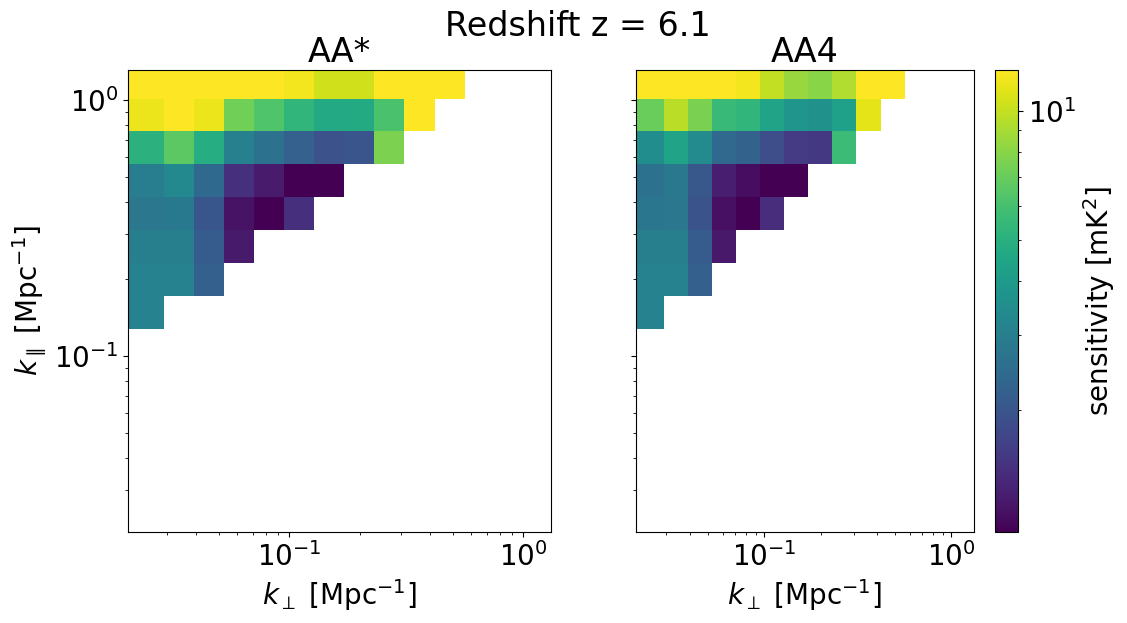

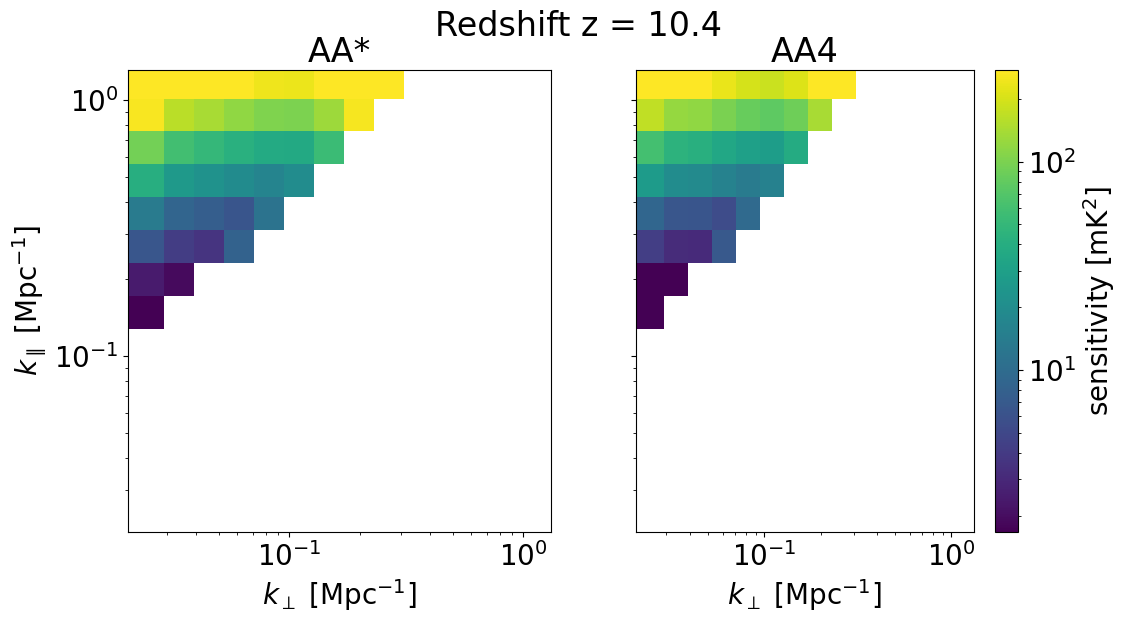

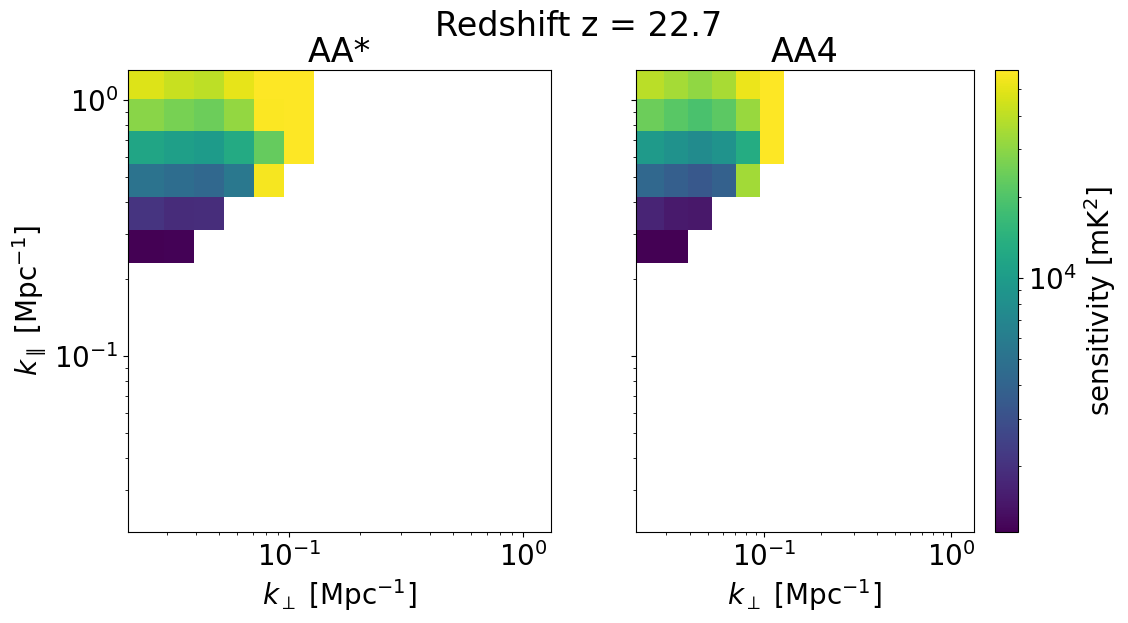

In [34]:
for z in zs[::-1][z_idx]:
    compare_senses(
        ska_aaast_senses2,
        ska_aa4_senses2,
        z,
        sense_params["kperp_mpc"],
        sense_params["kpar_mpc"],
        label1="AA*",
        label2="AA4",
        plot_1d=False,
    )

## Drift Scan Survey

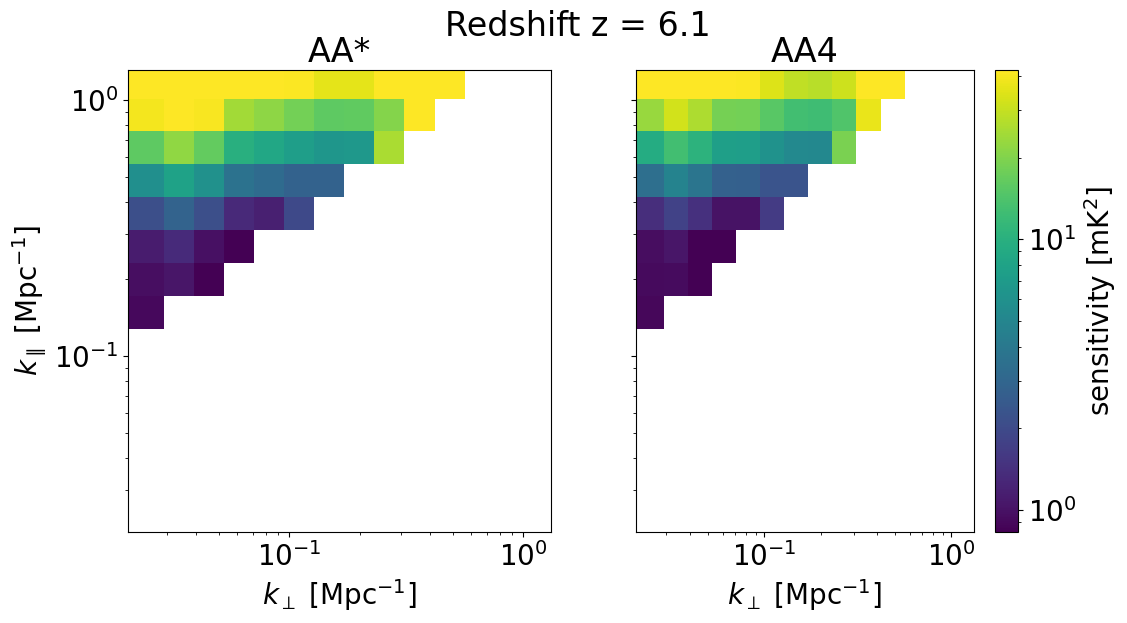

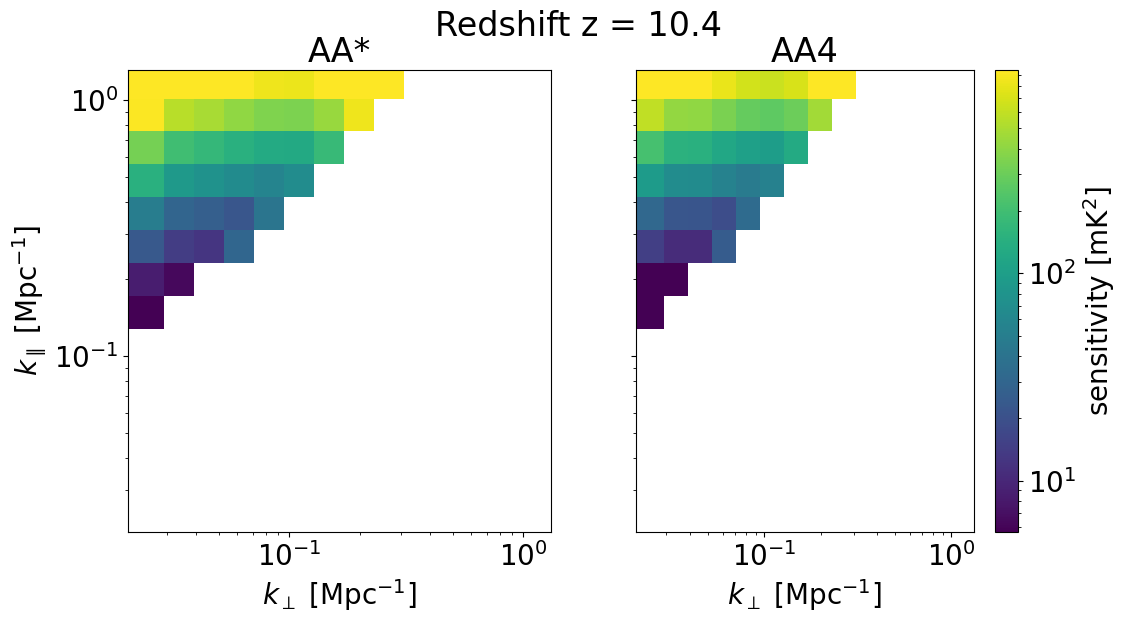

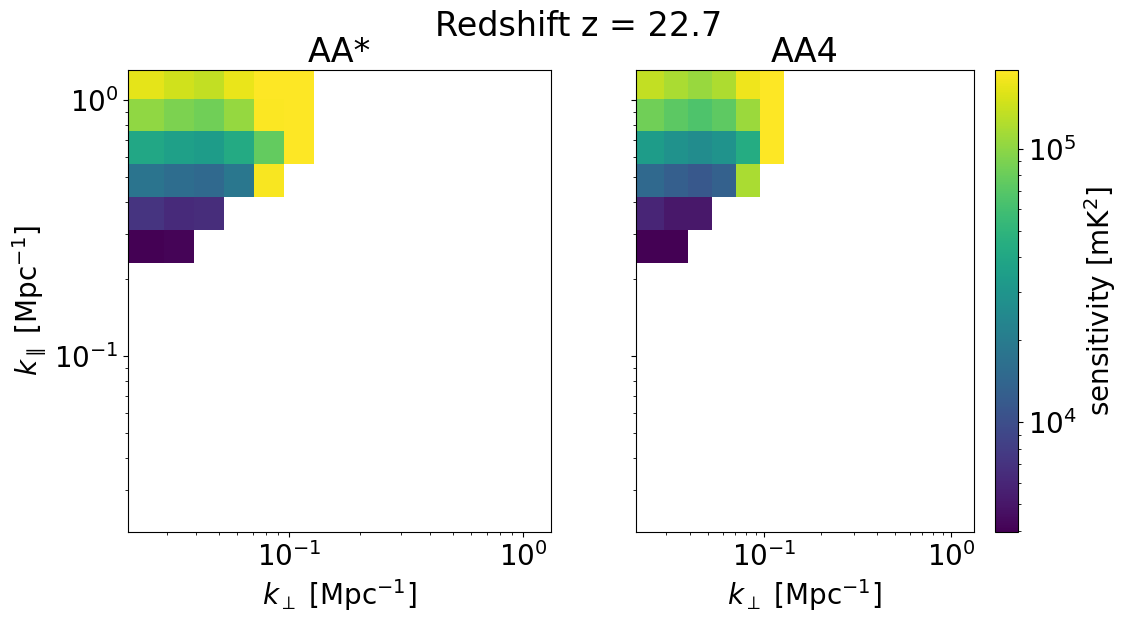

In [35]:
for z in zs[::-1][z_idx]:
    compare_senses(
        ska_aaast_senses3,
        ska_aa4_senses3,
        z,
        sense_params["kperp_mpc"],
        sense_params["kpar_mpc"],
        label1="AA*",
        label2="AA4",
        plot_1d=False,
    )

## Deep survey with optimistic foreground removal

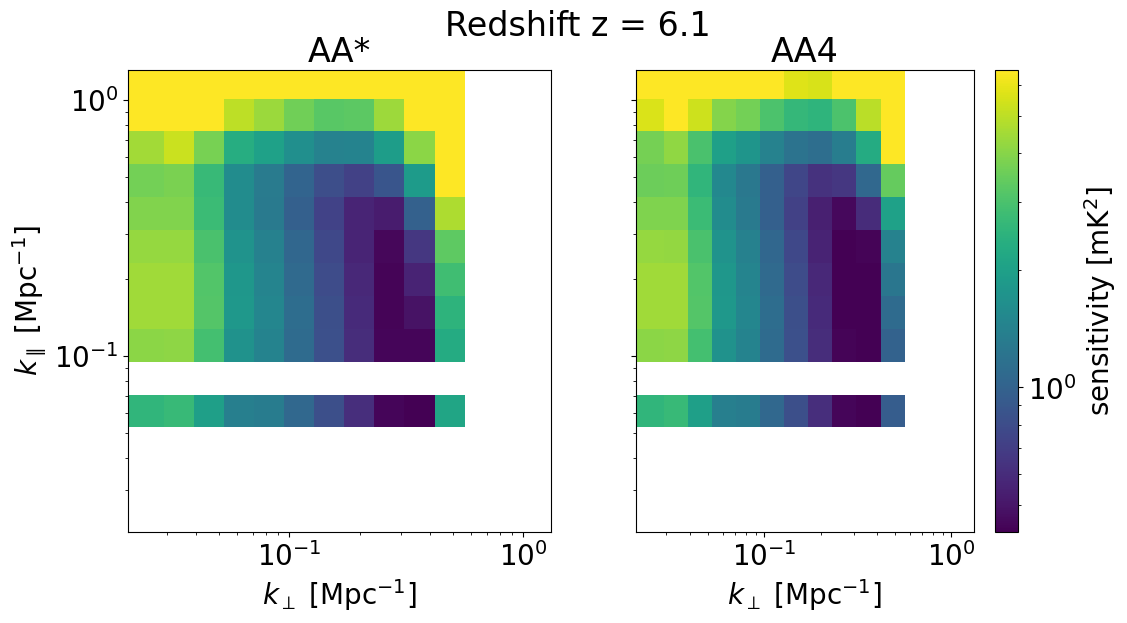

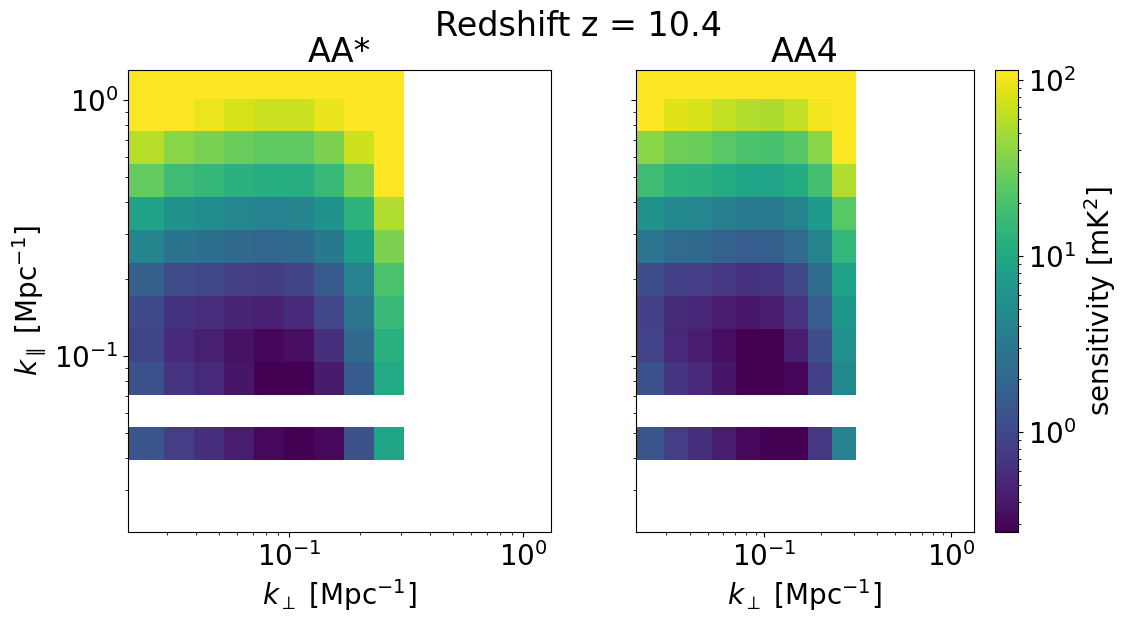

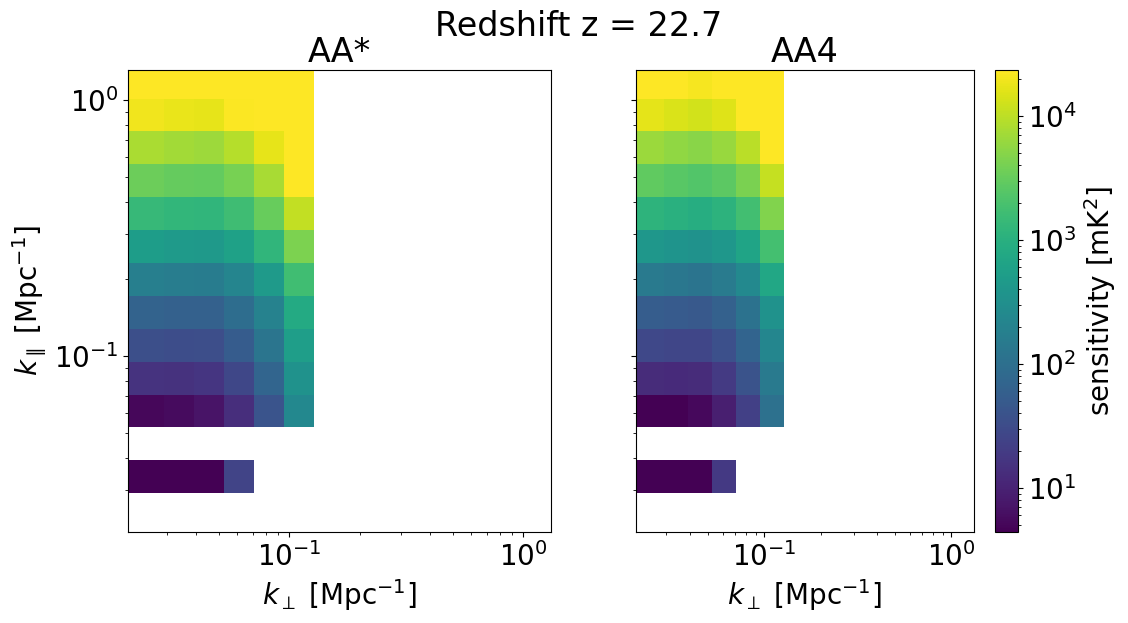

In [36]:
for z in zs[::-1][z_idx]:
    compare_senses(
        ska_aaast_senses4,
        ska_aa4_senses4,
        z,
        sense_params["kperp_mpc"],
        sense_params["kpar_mpc"],
        label1="AA*",
        label2="AA4",
        plot_1d=False,
    )